In [28]:
import os
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from sklearn.utils import shuffle
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import OrderedDict

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

import os
print(os.getcwd())

/content


In [3]:
import zipfile
if "/kaggle/working/food-101.zip" in os.listdir():
    print("Dataset already exists")
else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz > /dev/null 2>&1
    print("Extraction done!")

--2024-07-07 19:47:17--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-07-07 19:47:18--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  23.9MB/s    in 3m 24s  

2024-07-07 19:50:42 (23.4 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]

Dataset downloaded!
Extracting data..
Extraction done!


In [4]:
import shutil
import os

# Define the path to the source directory
source_dir = '/content/food-101'

# Define the destination directory
destination_dir = '/kaggle/working/'

# Copy the directory
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

print(f"Copied {source_dir} to {destination_dir}")

# Optionally, list the contents of the destination directory to verify
print("Contents of the destination directory:")
print(os.listdir(destination_dir))

Copied /content/food-101 to /kaggle/working/
Contents of the destination directory:
['meta', 'README.txt', 'license_agreement.txt', 'images']


In [5]:
classes = open("/kaggle/working/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']
classes_21, len(classes_21)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'other'],
 21)

In [6]:
!echo "Testing images"
!head -n 5 /kaggle/working/meta//test.txt
!echo -e "\nTraining images"
!head -n 5 /kaggle/working/meta/train.txt | head -n 5

Testing images
apple_pie/1011328
apple_pie/101251
apple_pie/1034399
apple_pie/103801
apple_pie/1038694

Training images
apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283


In [7]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

def prep_df(path: str) -> pd.DataFrame:
    # Read lines from the file
    array = open(path, 'r').read().splitlines()

    # Base path where images are located
    base_path = "/kaggle/working/images/"

    # Initialize lists to store labels and full paths
    labels = []
    full_paths = []

    # Iterate over each line in the array
    for line in array:
        # Split the line into label and image filename
        parts = line.split('/')
        label = parts[0]  # Assuming label is the first part before '/'
        img_filename = parts[1]  # Assuming image filename is the second part after '/'

        # Construct full path to the image
        img_path = base_path + label + "/" + img_filename + ".jpg"

        # Append label and full path to respective lists
        labels.append(label)
        full_paths.append(img_path)

    # Create a DataFrame from lists of labels and full paths
    imgs_df = pd.DataFrame({
        'label': labels,
        'path': full_paths
    })

    # Shuffle the DataFrame to randomize the order
    imgs_df = shuffle(imgs_df)

    return imgs_df

In [8]:
train_imgs = prep_df('/kaggle/working/meta/train.txt')
test_imgs = prep_df('/kaggle/working/meta/test.txt')

train_imgs.head(5)

,label,path
51372,onion_rings,/kaggle/working/images/onion_rings/2754690.jpg
37688,grilled_salmon,/kaggle/working/images/grilled_salmon/1931549.jpg
23966,donuts,/kaggle/working/images/donuts/851374.jpg
49349,mussels,/kaggle/working/images/mussels/3836089.jpg
3448,beef_tartare,/kaggle/working/images/beef_tartare/315595.jpg


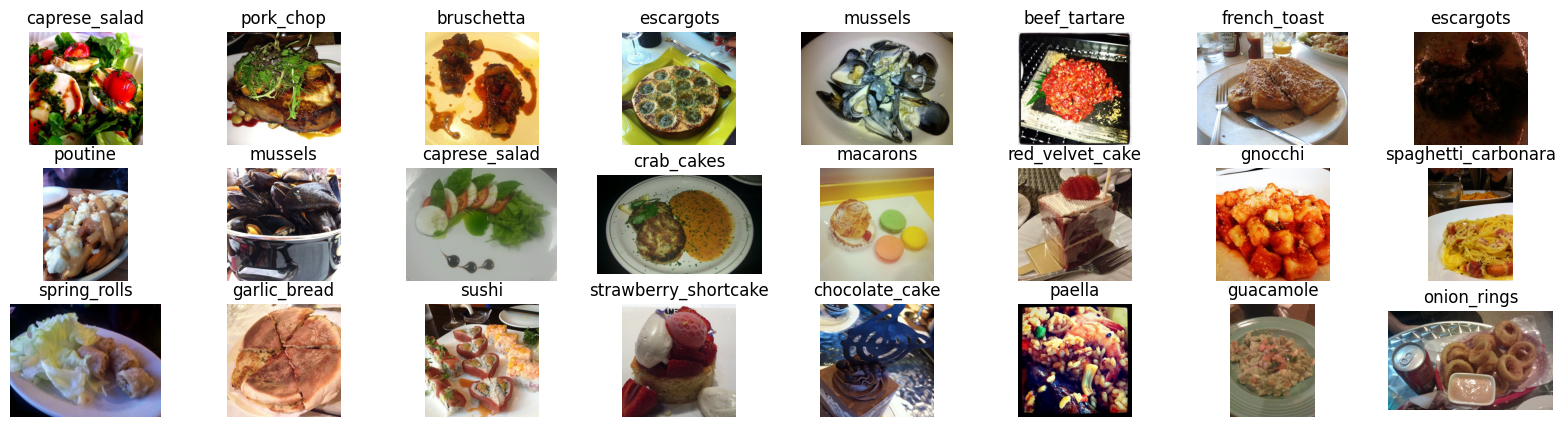

In [9]:
plt.figure(figsize=(20, 5))

num_rows = 3
num_cols = 8


for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])

    label = train_imgs.label.iloc[random_idx]

    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

In [10]:
# Data augmentation for training
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
# Data augmentation for testing
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [11]:
class Label_encoder:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(classes)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder = Label_encoder(classes)
for i in range(20):
    print(encoder.get_label(i), encoder.get_idx( encoder.get_label(i) ))

apple_pie 0
baby_back_ribs 1
baklava 2
beef_carpaccio 3
beef_tartare 4
beet_salad 5
beignets 6
bibimbap 7
bread_pudding 8
breakfast_burrito 9
bruschetta 10
caesar_salad 11
cannoli 12
caprese_salad 13
carrot_cake 14
ceviche 15
cheesecake 16
cheese_plate 17
chicken_curry 18
chicken_quesadilla 19


In [12]:
class Food20(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = encoder.get_idx(self.dataframe.label.iloc[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
train_dataset = Food20(train_imgs, transform=train_transforms)
test_dataset = Food20(test_imgs, transform=test_transforms)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [15]:
# Testing the retrieval of a single image
for i in range(10):
    image = train_dataset.__getitem__(i)
    print(encoder.get_label(image[1]), image[0].shape)

onion_rings torch.Size([3, 224, 224])
grilled_salmon torch.Size([3, 224, 224])
donuts torch.Size([3, 224, 224])
mussels torch.Size([3, 224, 224])
beef_tartare torch.Size([3, 224, 224])
hot_dog torch.Size([3, 224, 224])
hummus torch.Size([3, 224, 224])
filet_mignon torch.Size([3, 224, 224])
eggs_benedict torch.Size([3, 224, 224])
ceviche torch.Size([3, 224, 224])


In [16]:
weights = models.DenseNet201_Weights.IMAGENET1K_V1
model = models.densenet201(weights = weights)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 98.3MB/s]


In [17]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [18]:
import requests as reqs

url = "https://github.com/Prakhar998/Food-Classification/raw/master/food_classifier.pt"
r = reqs.get(url, allow_redirects=True)

open("./food_classifier.pt", "wb").write(r.content)

81841763

In [19]:
checkpoint_path = "./food_classifier.pt"
classifier = nn.Sequential(
    nn.Linear(1920,1024),
    nn.LeakyReLU(),
    nn.Linear(1024,101),
)

model.classifier = classifier
model.load_state_dict(torch.load(checkpoint_path,map_location='cpu'),strict=False)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [20]:
#hyper parameters
num_epochs = 3

# loss
loss_fn = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

model = model.to(device)

In [21]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  print("--> Training Progress")
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(tqdm(dataloader)):
      # Send data to target device
      images, labels = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(images)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, labels)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [22]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      print("--> Testing Progress")
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          # Send data to target device
          images, labels = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(images)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, labels)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

          test_acc += ((test_pred_labels == labels).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [23]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
    # Create empty results dictionary
    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        'best train acc': (0, 0),
        "best_model": dict()
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))

        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
            f"\n\n=============================\n"
        )

        # Update results dictionary
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        if test_loss < history["test_acc"][len(history["test_acc"]) - 1]:
            history["best_model"] = model.state_dict()

        if test_acc > 0.95:
            break

    # Return the filled results at the end of the epochs
    return model, history

In [24]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, num_epochs, device)

Epoch 1/3
--> Training Progress


100%|██████████| 592/592 [15:38<00:00,  1.59s/it]


--> Testing Progress


100%|██████████| 198/198 [04:27<00:00,  1.35s/it]


Epoch: 1 | train_loss: 1.1232 | train_acc: 0.7100 | test_loss: 0.3262 | test_acc: 0.9049


Epoch 2/3
--> Training Progress


100%|██████████| 592/592 [15:11<00:00,  1.54s/it]


--> Testing Progress


100%|██████████| 198/198 [04:34<00:00,  1.38s/it]


Epoch: 2 | train_loss: 1.0738 | train_acc: 0.7209 | test_loss: 0.3076 | test_acc: 0.9114


Epoch 3/3
--> Training Progress


100%|██████████| 592/592 [14:36<00:00,  1.48s/it]


--> Testing Progress


100%|██████████| 198/198 [04:10<00:00,  1.26s/it]

Epoch: 3 | train_loss: 1.0570 | train_acc: 0.7263 | test_loss: 0.2975 | test_acc: 0.9149




In [25]:
#Remove
def evaluate(model, dataloader):

  random = np.random.randint(0, len(dataloader))

  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_samples = 0

    for images, labels in tqdm(dataloader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      preds = torch.argmax(torch.softmax(outputs, 1), 1)

      # Converting this problem to a problem with 21 clases only
      preds = np.array([pred.cpu() if pred < 20 else 20 for pred in preds])
      labels = np.array([label.cpu() if label < 20 else 20 for label in labels])

      n_samples += labels.shape[0]
      n_correct += (preds==labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(acc)

In [26]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

def evaluate(model, dataloader):
    device = next(model.parameters()).device  # Get the device of the model
    model.eval()
    n_correct = 0
    n_samples = 0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        preds = torch.argmax(torch.softmax(outputs, 1), 1)

        # Converting predictions and labels to numpy arrays
        preds_np = preds.cpu().numpy()
        labels_np = labels.cpu().numpy()

        # Store all predictions and labels for later metrics calculation
        all_preds.extend(preds_np)
        all_labels.extend(labels_np)

        n_samples += labels.size(0)
        n_correct += (preds == labels).sum().item()

    # Calculate accuracy
    acc = 100.0 * n_correct / n_samples

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Generate classification report
    class_report = classification_report(all_labels, all_preds)

    print(f'Accuracy: {acc:.2f}%')
    print(f'F1 Score: {f1:.4f}%')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)

    return acc, f1, conf_matrix, class_report

In [29]:
evaluate(model,test_loader)

100%|██████████| 198/198 [04:12<00:00,  1.27s/it]

Accuracy: 91.47%
F1 Score: 0.9147%
Confusion Matrix:
[[213   1   0 ...   2   0   2]
 [  0 231   0 ...   0   1   0]
 [  5   0 237 ...   1   0   0]
 ...
 [  2   1   0 ... 236   0   0]
 [  0   0   0 ...   0 198   0]
 [  0   0   0 ...   0   0 244]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       250
           1       0.89      0.92      0.91       250
           2       0.99      0.95      0.97       250
           3       0.90      0.97      0.94       250
           4       0.91      0.87      0.89       250
           5       0.81      0.92      0.86       250
           6       0.96      0.94      0.95       250
           7       0.94      0.98      0.96       250
           8       0.87      0.76      0.81       250
           9       0.92      0.89      0.90       250
          10       0.86      0.90      0.88       250
          11       0.86      0.95      0.90       250
          12       0.94      

(91.46534653465346,
 0.9146858306689128,
 array([[213,   1,   0, ...,   2,   0,   2],
        [  0, 231,   0, ...,   0,   1,   0],
        [  5,   0, 237, ...,   1,   0,   0],
        ...,
        [  2,   1,   0, ..., 236,   0,   0],
        [  0,   0,   0, ...,   0, 198,   0],
        [  0,   0,   0, ...,   0,   0, 244]]),
 '              precision    recall  f1-score   support\n\n           0       0.85      0.85      0.85       250\n           1       0.89      0.92      0.91       250\n           2       0.99      0.95      0.97       250\n           3       0.90      0.97      0.94       250\n           4       0.91      0.87      0.89       250\n           5       0.81      0.92      0.86       250\n           6       0.96      0.94      0.95       250\n           7       0.94      0.98      0.96       250\n           8       0.87      0.76      0.81       250\n           9       0.92      0.89      0.90       250\n          10       0.86      0.90      0.88       250\n          

In [30]:
class Label_encoder_21:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder_21 = Label_encoder(classes_21)
encoder_21.get_label(0), encoder.get_idx( encoder_21.get_label(0) )

('apple_pie', 0)

In [31]:
#This line of code saves the best model's state dictionary (or parameters) from the training history to a file named solution.pth.
torch.save(history['best_model'], "./solution.pth")

In [32]:
import os

if os.path.exists("./solution.pth"):
    print("solution.pth exists in the current directory.")
else:
    print("solution.pth does not exist in the current directory.")

solution.pth exists in the current directory.


In [33]:
torch.save(model.state_dict(), 'saved_model.pth')

In [34]:
import torch
from PIL import Image
from torchvision import transforms

def classify_image(image_path, model, label_encoder, device):
    # Load and preprocess the input image
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Perform prediction
    with torch.no_grad():
        model.eval()
        output = model(image_tensor)

    # Get predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()

    # Map index to class name
    predicted_label = label_encoder.get_label(predicted_idx)

    return predicted_label

# Load the saved model and label encoder
model = models.densenet201(weights=None)
classifier = nn.Sequential(
    nn.Linear(1920, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 101),
)
model.classifier = classifier
model.load_state_dict(torch.load("solution.pth", map_location=device))
model.to(device)
model.eval()

label_encoder = Label_encoder(classes)


# Classify an image
image_path = "/kaggle/working/images/ice_cream/988684.jpg"  # Replace with the path to your image
predicted_label = classify_image(image_path, model, label_encoder, device)
print("Predicted Label:", predicted_label)

Predicted Label: ice_cream


In [35]:
# Define the model architecture
model = models.densenet201(weights=None)
classifier = nn.Sequential(
    nn.Linear(1920, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 101),
)
model.classifier = classifier

# Load the trained model parameters
model.load_state_dict(torch.load("solution.pth", map_location=torch.device('cpu')))
model.to(device)
model.eval()

# Define a dummy input for tracing
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Convert the model to TorchScript using tracing
traced_model = torch.jit.trace(model, dummy_input)

# Save the TorchScript model
traced_model.save("model_scripted.pt")

print("Model converted to TorchScript and saved as 'model_scripted.pt'")

Model converted to TorchScript and saved as 'model_scripted.pt'


In [36]:
# Load the TorchScript model
scripted_model = torch.jit.load("model_scripted.pt")
scripted_model.to(device)
scripted_model.eval()

def classify_image_with_scripted_model(image_path, model, label_encoder, device):
    # Load and preprocess the input image
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)

    # Get predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()

    # Map index to class name
    predicted_label = label_encoder.get_label(predicted_idx)

    return predicted_label

# Classify an image using the TorchScript model
image_path = "/kaggle/working/images/ice_cream/988684.jpg"  # Replace with the path to your image
predicted_label = classify_image_with_scripted_model(image_path, scripted_model, label_encoder, device)
print("Predicted Label with Scripted Model:", predicted_label)

Predicted Label with Scripted Model: ice_cream


In [37]:
import torch
from PIL import Image, UnidentifiedImageError
from torchvision import transforms
import requests
from io import BytesIO

# Assume you have already loaded and prepared your TorchScript model and label encoder
scripted_model = torch.jit.load("model_scripted.pt")
scripted_model.to(device)
scripted_model.eval()

# Define the function to classify an image with the TorchScript model
def classify_image_with_scripted_model(image, model, label_encoder, device):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)

    # Get predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()

    # Map index to class name
    predicted_label = label_encoder.get_label(predicted_idx)

    return predicted_label

# Function to classify an image from a Google URL
def classify_google_image(url, model, label_encoder, device):
    try:
        # Fetch the image from the URL
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad responses

        # Open the image using PIL
        image = Image.open(BytesIO(response.content))

        # Check if the image could be opened
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Classify the image using the existing function
        predicted_label = classify_image_with_scripted_model(image, model, label_encoder, device)

        return predicted_label

    except requests.exceptions.HTTPError as errh:
        print(f"HTTP Error: {errh}")
    except requests.exceptions.ConnectionError as errc:
        print(f"Error Connecting: {errc}")
    except requests.exceptions.Timeout as errt:
        print(f"Timeout Error: {errt}")
    except requests.exceptions.RequestException as err:
        print(f"Request Exception: {err}")
    except UnidentifiedImageError as ui_err:
        print(f"Unidentified Image Error: {ui_err}")
    except Exception as e:
        print(f"Exception occurred: {e}")

    return None

# Example usage: Classify an image from a Google URL
google_image_url = "https://static8.depositphotos.com/1005629/806/i/450/depositphotos_8068134-stock-photo-pasta-with-olives-and-parsley.jpg"  # Replace with your actual image URL
predicted_label = classify_google_image(google_image_url, scripted_model, label_encoder, device)
if predicted_label:
    print("Predicted Label with Scripted Model:", predicted_label)
else:
    print("Failed to classify image.")

Predicted Label with Scripted Model: spaghetti_carbonara
